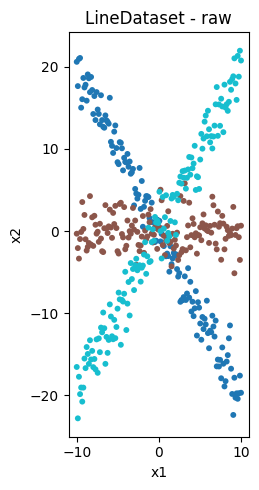

LineDataset - train accuracy: 0.8688888888888889


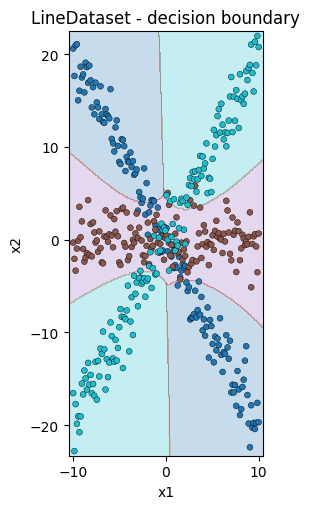

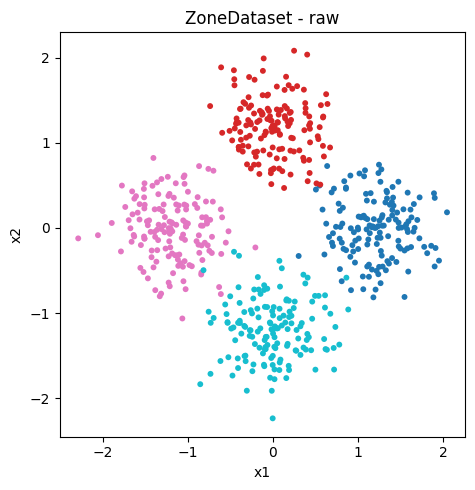

ZoneDataset - train accuracy: 0.9833333333333333


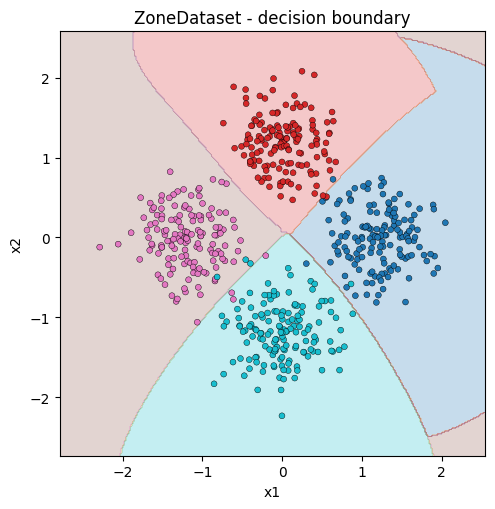

LineDataset (as regression) - R^2: 0.973889523938407


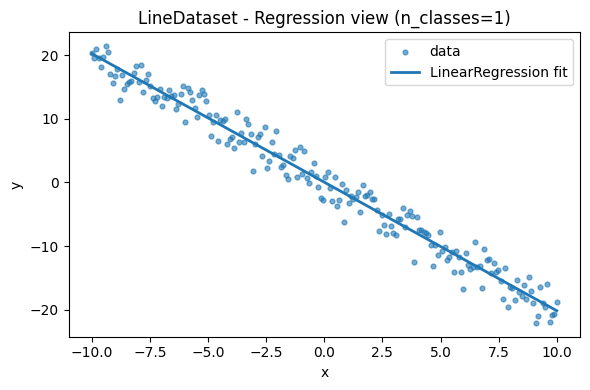

In [3]:
# ===== imports =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from typing import Optional, Tuple

class LineDataset:
    """
    Generate a multi-class line dataset in 2D.

    Each class corresponds to a line of the form:
        y = a_k * x + b
    where
        - a_k is the slope assigned to class k
        - b is a Gaussian random offset

    Construction:
        • x is sampled uniformly from [-10, 10] using linspace
        • y is generated using the line equation with noise
        • Labels y[i] = k for all points of class k

    Parameters
    ----------
    points_per_class : int
        Number of points per class.
    n_classes : int
        Number of lines (classes).
    n_dimensions : int
        Dimensionality of the dataset (currently only supports 2).
    noise_scale : float, default=2.0
        Standard deviation of Gaussian noise added to the intercept b.
    random_state : int | None, default=None
        Seed for reproducibility.

    Returns (via .generate())
    -------------------------
    X : np.ndarray, shape (points_per_class * n_classes, 2)
        Data points (x, y).
    y : np.ndarray, shape (points_per_class * n_classes,)
        Integer labels in [0, n_classes-1].
    """

    def __init__(self, points_per_class: int, n_classes: int,
                    n_dimensions: int = 2, noise_scale: float = 2.0,
                    random_state: Optional[int] = None
    ) -> None:
        if n_dimensions != 2:
            raise ValueError("Currently only 2D datasets are supported.")

        self.points_per_class = points_per_class
        self.n_classes = n_classes
        self.n_dimensions = n_dimensions
        self.noise_scale = noise_scale
        self.rng = np.random.default_rng(random_state)

        n_total = points_per_class * n_classes
        self.X = np.zeros((n_total, n_dimensions), dtype=float)
        self.y = np.zeros(n_total, dtype=np.uint8)

        # Generate data for each class
        for k in range(n_classes):
            # Range of indices for class k
            idx = slice(k * points_per_class, (k + 1) * points_per_class)

            # X-axis values evenly spaced
            x = np.linspace(-10, 10, points_per_class)

            # Slope for class k
            slope = 2 * k - 2   # e.g. -2, 0, 2, 4, ...
            # Random Gaussian intercept
            intercept = self.rng.normal(0.0, noise_scale, points_per_class)

            # Compute y = slope * x + intercept
            y_vals = slope * x + intercept

            # Store in dataset
            self.X[idx, 0] = x
            self.X[idx, 1] = y_vals
            self.y[idx] = k

    def generate(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return (X, y)."""
        return self.X, self.y



class ZoneDataset:
    """
    Generate a 2D multi-class 'zone' dataset: each class is a small noisy ring
    centered on points uniformly placed on a big circle.

    Construction
    ------------
    For class k (k = 0..C-1):
        Center on the unit circle (scaled by R_center):
            θ_k = 2π k / C
            c_k = (R_center cos θ_k, R_center sin θ_k)

        Sample a ring around c_k with angular and radial noise:
            t_i = linspace(0, 2π, N) + 𝒩(0, σ_θ²)
            ρ_i = R_ring + 𝒩(0, σ_ρ²)

        Cartesian mapping:
            x_i = c_k.x + ρ_i cos(t_i)
            y_i = c_k.y + ρ_i sin(t_i)

    Parameters
    ----------
    points_per_class : int
        Number of points per class (N).
    n_classes : int
        Number of zones / rings (C).
    center_radius : float, default=1.0
        Radius of the big circle where class centers lie (R_center).
    ring_radius : float, default=0.5
        Mean radius of each local ring around its center (R_ring).
    angular_noise : float, default=0.2
        Std-dev of Gaussian noise added to angle t (σ_θ).
    radial_noise : float, default=0.5
        Std-dev of Gaussian noise added to radius ρ (σ_ρ).
    random_state : int | None, default=None
        Seed for reproducibility.

    Returns (via .generate())
    -------------------------
    X : np.ndarray, shape (points_per_class * n_classes, 2)
        2D data points.
    y : np.ndarray, shape (points_per_class * n_classes,)
        Integer labels in [0, n_classes-1].
    """

    def __init__(self, points_per_class: int,
                    n_classes: int, center_radius: float = 1.0,
                    ring_radius: float = 0.5, angular_noise: float = 0.2,
                    radial_noise: float = 0.5, 
                    random_state: Optional[int] = None,) -> None:
        if points_per_class <= 0:
            raise ValueError("points_per_class must be > 0.")
        if n_classes <= 0:
            raise ValueError("n_classes must be > 0.")
        if center_radius <= 0:
            raise ValueError("center_radius must be > 0.")
        if ring_radius <= 0:
            raise ValueError("ring_radius must be > 0.")

        self.points_per_class = points_per_class
        self.n_classes = n_classes
        self.center_radius = center_radius
        self.ring_radius = ring_radius
        self.angular_noise = angular_noise
        self.radial_noise = radial_noise
        self.rng = np.random.default_rng(random_state)

        n_total = points_per_class * n_classes
        self.X = np.zeros((n_total, 2), dtype=float)
        self.y = np.zeros(n_total, dtype=np.uint8)

        # Precompute a clean angular sweep (shared shape) then add noise per class
        base_t = np.linspace(0.0, 2.0 * np.pi, points_per_class)

        for k in range(n_classes):
            idx = slice(k * points_per_class, (k + 1) * points_per_class)

            # Center of class k on the big circle
            theta_k = 2.0 * np.pi * k / n_classes
            cx = center_radius * np.cos(theta_k)
            cy = center_radius * np.sin(theta_k)

            # Noisy angle and radius for the ring
            t = base_t + self.rng.normal(0.0, self.angular_noise, points_per_class)
            rho = self.ring_radius + self.rng.normal(0.0, self.radial_noise, points_per_class)

            # Polar → Cartesian around the class center
            self.X[idx, 0] = cx + rho * np.cos(t)
            self.X[idx, 1] = cy + rho * np.sin(t)
            self.y[idx] = k

    def generate(self) -> Tuple[np.ndarray, np.ndarray]:
        """Return (X, y)."""
        return self.X, self.y

# ===== helpers =====
def plot_data(X, y, title="Data"):
    plt.figure(figsize=(5.5, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=18, cmap="tab10", edgecolor="none")
    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

def plot_decision_boundary(X, y, clf, title="Decision boundary"):
    # tạo lưới để vẽ boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6, 5.2))
    plt.contourf(xx, yy, Z, alpha=0.25, cmap="tab10")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=18, cmap="tab10", edgecolor="k", linewidth=0.3)
    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

# ===== your datasets (paste your class definitions above this line or import them) =====
# (Giả sử bạn đã định nghĩa LineDataset và ZoneDataset đúng như bạn gửi)

# -------------------------------
# 1) TEST LineDataset (Classification)
# -------------------------------
line_ds = LineDataset(points_per_class=150, n_classes=3, random_state=42)
X_line, y_line = line_ds.generate()

plot_data(X_line, y_line, title="LineDataset - raw")

# Model: SVC (RBF) + scale (phù hợp dữ liệu phi tuyến/đường chéo)
line_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=2.0, gamma="scale", random_state=42))
line_clf.fit(X_line, y_line)
pred_line = line_clf.predict(X_line)
print("LineDataset - train accuracy:", accuracy_score(y_line, pred_line))

plot_decision_boundary(X_line, y_line, line_clf, title="LineDataset - decision boundary")

# -------------------------------
# 2) TEST ZoneDataset (Classification)
# -------------------------------
zone_ds = ZoneDataset(points_per_class=150, n_classes=4,
                      center_radius=1.2, ring_radius=0.45,
                      angular_noise=0.25, radial_noise=0.25,
                      random_state=7)
X_zone, y_zone = zone_ds.generate()

plot_data(X_zone, y_zone, title="ZoneDataset - raw")

zone_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=2.0, gamma="scale", random_state=7))
zone_clf.fit(X_zone, y_zone)
pred_zone = zone_clf.predict(X_zone)
print("ZoneDataset - train accuracy:", accuracy_score(y_zone, pred_zone))

plot_decision_boundary(X_zone, y_zone, zone_clf, title="ZoneDataset - decision boundary")

# -------------------------------
# (Optional) 3) LineDataset as Regression (n_classes=1)
# -------------------------------
line_reg_ds = LineDataset(points_per_class=200, n_classes=1, random_state=0)
X_linereg, _y_cls = line_reg_ds.generate()

# dùng cột x làm input, cột y làm target liên tục
x_feat = X_linereg[:, 0].reshape(-1, 1)
y_target = X_linereg[:, 1]

reg = LinearRegression()
reg.fit(x_feat, y_target)
r2 = r2_score(y_target, reg.predict(x_feat))
print("LineDataset (as regression) - R^2:", r2)

# vẽ regression
xx = np.linspace(x_feat.min(), x_feat.max(), 300).reshape(-1, 1)
yy_hat = reg.predict(xx)

plt.figure(figsize=(6, 4))
plt.scatter(x_feat, y_target, s=12, alpha=0.6, label="data")
plt.plot(xx, yy_hat, linewidth=2, label="LinearRegression fit")
plt.title("LineDataset - Regression view (n_classes=1)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import numpy as np

def batch_iterator(X, y, batch_size=32, shuffle=True):
    len_samples = len(X)
    indices = np.arange(len_samples)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, len_samples, batch_size):
        end = min(start + batch_size, len_samples)
        batch_indices = indices[start:end]
        return X[batch_indices], y[batch_indices]

In [11]:
batch_iterator(X, y, batch_size=4, shuffle=False)

(array([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]]),
 array([0, 1, 2, 3]))

In [ ]:


# ==== TEST ====

# Fake data
X = np.arange(20).reshape(10, 2)   # 10 samples, 2 features
y = np.arange(10)                  # labels 0..9

print("Full dataset:")
print("X:\n", X)
print("y:", y)

print("\nIterating with batch_size=4 (shuffle=False):")
for Xb, yb in batch_iterator(X, y, batch_size=4, shuffle=False):
    print("Batch X:\n", Xb)
    print("Batch y:", yb)
    print("---")

print("\nIterating with batch_size=3 (shuffle=True):")
for Xb, yb in batch_iterator(X, y, batch_size=3, shuffle=True):
    print("Batch X:\n", Xb)
    print("Batch y:", yb)
    print("---")


In [ ]:
import numpy as np

rng = np.random.default_rng(42)          # 42 là seed
idx_perm  = rng.permutation(100)         # hoán vị 0..99
idx_k     = rng.choice(100, 20, replace=False)  # chọn 20 index khác nhau
idx_rep   = rng.integers(0, 100, 20)     # 20 index, có thể trùng (with replacement)


In [20]:
idx_perm

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90,  4, 76,
       77, 12, 31, 55, 88, 26, 42, 69, 15, 40, 96,  9, 72, 11, 47, 85, 28,
       93,  5, 66, 65, 35, 16, 49, 34,  7, 95, 27, 19, 81, 25, 62, 13, 24,
        3, 17, 38,  8, 78,  6, 64, 36, 89, 56, 99, 54, 43, 50, 67, 46, 68,
       61, 97, 79, 41, 58, 48, 98, 57, 75, 32, 94, 59, 63, 84, 37, 29,  1,
       52, 21,  2, 23, 87, 91, 74, 86, 82, 20, 60, 71, 14, 92, 51],
      dtype=int32)

In [18]:
mask = np.ones_like(idx_perm)
mask[idx_k] = False
mask

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

In [21]:
idx_perm[mask == 1]

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90, 12, 31,
       88, 26, 42, 69, 40, 96,  9, 72, 47, 85, 28, 93,  5, 66, 35, 49, 34,
        7, 95, 27, 19, 81, 25, 62, 24,  3, 17, 38, 64, 36, 56, 99, 54, 43,
       50, 68, 61, 97, 79, 41, 58, 98, 57, 75, 32, 94, 63, 84, 37, 29,  1,
       52, 21, 23, 87, 91, 74, 86, 20, 60, 71, 14, 92], dtype=int32)

In [22]:
idx_perm[mask == 0]

array([ 4, 76, 77, 55, 15, 11, 65, 16, 13,  8, 78,  6, 89, 67, 46, 48, 59,
        2, 82, 51], dtype=int32)

In [23]:
def train_test_split_simple(X, y, seed=42, train_size=0.8, shuffle=True):
    X = np.asarray(X)
    y = np.asarray(y)
    if len(X) != len(y):
        raise ValueError("X and y must have the same length.")

    n = len(X)
    rng = np.random.default_rng(seed)

    idx = np.arange(n)
    if shuffle:
        idx = rng.permutation(idx)
    idx_train = rng.choice(n, int(0.8 * n), replace= False)

    mask = np.zeros(n, dtype=bool)
    mask[idx_train] = True
    X_train, X_test = X[mask], X[~mask]
    y_train, y_test = y[mask], y[~mask]

    return X_train, X_test, y_train, y_test

In [24]:
train_test_split_simple(idx_perm, idx_perm)

(array([53, 44, 39, 22, 80, 10,  0, 18, 30,  4, 76, 77, 12, 31, 55, 88, 26,
        42, 69, 15, 40, 96,  9, 72, 11, 47, 85, 28,  5, 65, 16, 49, 34,  7,
        95, 19, 81, 25, 13,  3, 17, 38,  8,  6, 64, 36, 89, 56, 99, 54, 43,
        50, 67, 46, 68, 61, 97, 79, 41, 48, 98, 75, 32, 94, 59, 63, 84, 37,
         1, 52, 21,  2, 87, 91, 20, 60, 71, 14, 92, 51], dtype=int32),
 array([83, 70, 45, 73, 33, 90, 93, 66, 35, 27, 62, 24, 78, 58, 57, 29, 23,
        74, 86, 82], dtype=int32),
 array([53, 44, 39, 22, 80, 10,  0, 18, 30,  4, 76, 77, 12, 31, 55, 88, 26,
        42, 69, 15, 40, 96,  9, 72, 11, 47, 85, 28,  5, 65, 16, 49, 34,  7,
        95, 19, 81, 25, 13,  3, 17, 38,  8,  6, 64, 36, 89, 56, 99, 54, 43,
        50, 67, 46, 68, 61, 97, 79, 41, 48, 98, 75, 32, 94, 59, 63, 84, 37,
         1, 52, 21,  2, 87, 91, 20, 60, 71, 14, 92, 51], dtype=int32),
 array([83, 70, 45, 73, 33, 90, 93, 66, 35, 27, 62, 24, 78, 58, 57, 29, 23,
        74, 86, 82], dtype=int32))